# Autoencoder

Train autoencoder to extract features from the images and improve classification. 

## 1. Undersampling Class "Negative"
To handle imbalanced dataset, set the count for each class into 1,000 images. 

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
# File paths
image_dir = '../images'
labels_df = pd.read_csv('../labels.csv')

In [3]:
# Define the target number of images per class
target_count = 1000

# Create an empty DataFrame to store the balanced dataset
balanced_df = pd.DataFrame(columns=labels_df.columns)

# Loop through each class
for label in labels_df['Label'].unique():
    # Filter rows for the current label
    label_df = labels_df[labels_df['Label'] == label]
    
    # Randomly sample 
    sampled_df = label_df.sample(n=target_count, random_state=42)
    
    # Add the sampled rows to the balanced dataset
    balanced_df = pd.concat([balanced_df, sampled_df])

# Extract file names and labels from the balanced dataset
image_filenames = balanced_df['Filename'].values
y = balanced_df['Label'].values

# Construct full image paths
image_paths = [os.path.join(image_dir, fname) for fname in image_filenames]

# Ensure images and labels are aligned
if len(image_paths) != len(y):
    raise ValueError("Number of images and labels do not match.")

In [4]:
print(len(image_paths))

9000


## 2. Training the AutoEncoder
Use a total of 9,000 images without labels to perform self-supervised learning.

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [6]:
# Load and preprocess images
def load_images(image_paths, target_size=(64, 64)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)
    return np.array(images)  # Convert list of arrays to a single NumPy array

# Load the dataset
image_data = load_images(image_paths)
X_train, X_val, y_train, y_val = train_test_split(image_data, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
print(f"Training X shape: {X_train.shape}")
print(f"Validation X shape: {X_val.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Validation y shape: {y_val.shape}")

Training X shape: (7200, 64, 64, 3)
Validation X shape: (1800, 64, 64, 3)
Training y shape: (7200,)
Validation y shape: (1800,)


In [8]:
# Define the Autoencoder architecture
input_shape = X_train.shape[1:]  # Shape of the images

# Encoder
input_img = Input(shape=input_shape)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) 
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [9]:
# Combine encoder and decoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=10,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, X_val)
)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 106ms/step - loss: 0.0528 - val_loss: 0.0426
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - loss: 0.0425 - val_loss: 0.0412
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - loss: 0.0417 - val_loss: 0.0404
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - loss: 0.0409 - val_loss: 0.0401
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - loss: 0.0402 - val_loss: 0.0396
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - loss: 0.0397 - val_loss: 0.0393
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - loss: 0.0396 - val_loss: 0.0389
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - loss: 0.0391 - val_loss: 0.0386
Epoch 9/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - loss: 0.0388 - val_loss: 0.0385
Epoch 10/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - loss: 0.0390 - val_loss: 0.0382


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


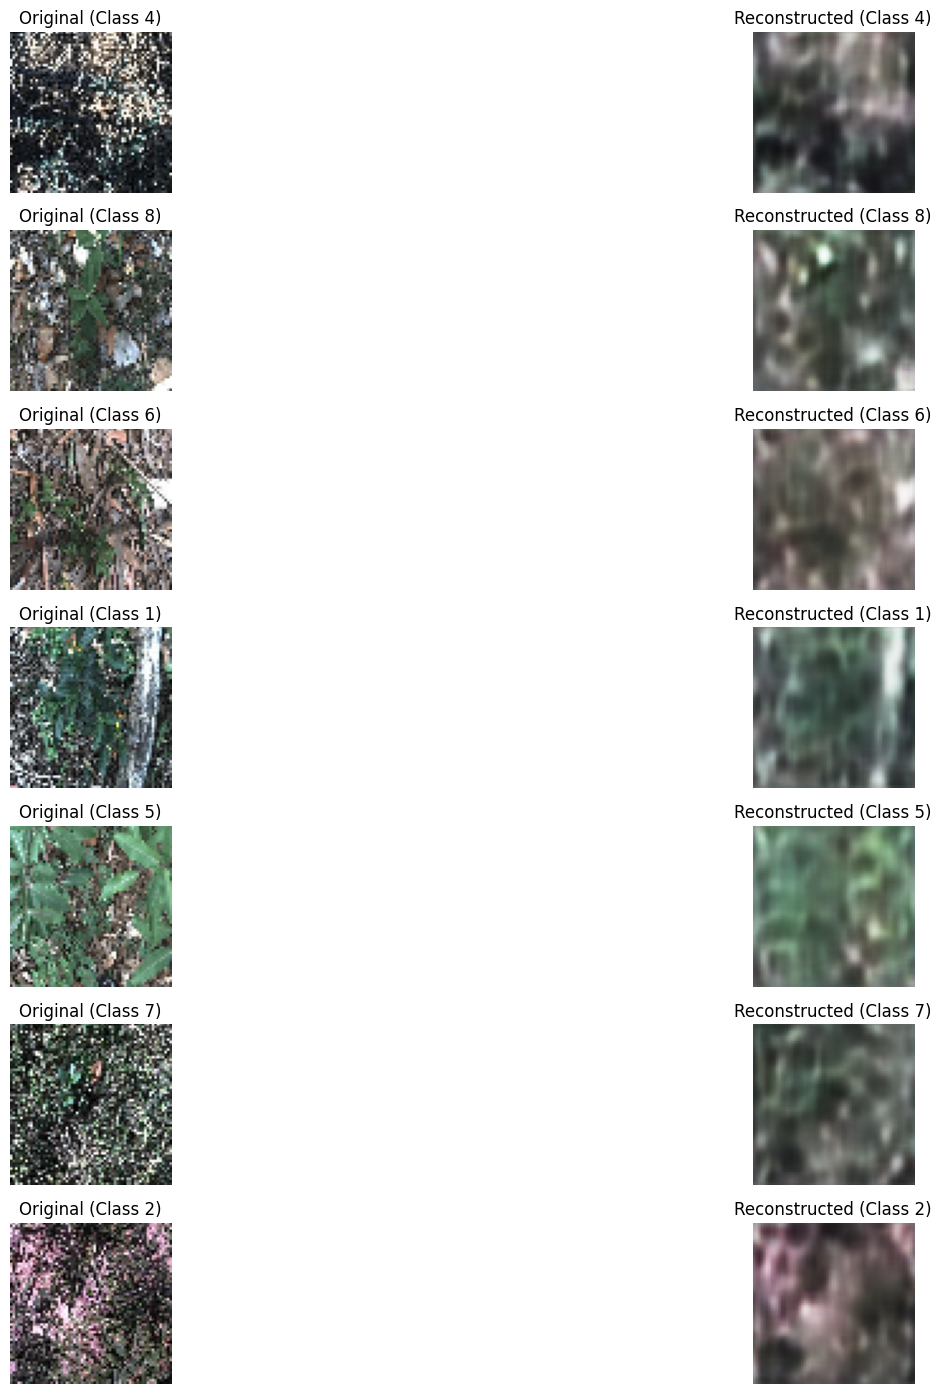

In [10]:
# Visualize reconstructed images
import matplotlib.pyplot as plt

def visualize_reconstruction_by_class(model, images, labels, n):
    plt.figure(figsize=(15, n * 2))
    
    # Keep track of displayed classes
    displayed_classes = set()

    for i in range(n):
        class_label = labels[i]
        if class_label not in displayed_classes:
            displayed_classes.add(class_label)

            # Original image
            plt.subplot(n, 2, len(displayed_classes) * 2 - 1)
            plt.imshow(images[i])
            plt.axis('off')
            plt.title(f"Original (Class {class_label})")
            
            # Reconstructed image
            reconstructed = model.predict(images[i][np.newaxis, ...])[0]
            plt.subplot(n, 2, len(displayed_classes) * 2)
            plt.imshow(reconstructed)
            plt.axis('off')
            plt.title(f"Reconstructed (Class {class_label})")

    plt.tight_layout()
    plt.show()

# Visualize reconstructions for all classes
visualize_reconstruction_by_class(autoencoder, X_val, y_val, n = 10)

## 3. Using the pre-trained AutoEncoder to train Linear Models (kNN, Random Forest, and SVM)

##### Replace the images with the reconstructed images obtained by the pre-trained autoencoder. 

In [11]:
X_train_final = autoencoder.predict(X_train)
X_test_final = autoencoder.predict(X_val)

y_train_final = y_train
y_test_final = y_val 

225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [12]:
print(X_train_final.shape)
print(X_test_final.shape)

print(y_train_final.shape)
print(y_test_final.shape)

(7200, 64, 64, 3)
(1800, 64, 64, 3)
(7200,)
(1800,)


In [13]:
from sklearn.preprocessing import LabelEncoder

# Convert labels to discrete values if necessary
label_encoder = LabelEncoder()
y_train_final = label_encoder.fit_transform(y_train_final)
y_test_final = label_encoder.transform(y_test_final)

# Flattening
X_train_final = X_train_final.reshape(X_train_final.shape[0], -1)  # Flattening each image
X_test_final = X_test_final.reshape(X_test_final.shape[0], -1)  # Flattening each image

### kNN using AutoEncoder 

In [14]:
from sklearn import neighbors

kNN = neighbors.KNeighborsClassifier(n_neighbors = 3, metric='euclidean')
kNN_model = kNN.fit(X_train_final, y_train_final)
y_pred1 = kNN_model.predict(X_test_final)

In [15]:
from sklearn.metrics import classification_report

print('training accuracy: %f' % kNN_model.score(X_train_final, y_train_final))
print('testing accuracy: %f' % kNN_model.score(X_test_final, y_test_final))
print(classification_report(y_test_final, y_pred1))

training accuracy: 0.499722
testing accuracy: 0.205556
              precision    recall  f1-score   support

           0       0.15      0.15      0.15       200
           1       0.28      0.18      0.22       200
           2       0.17      0.58      0.26       200
           3       0.18      0.09      0.12       200
           4       0.17      0.12      0.14       200
           5       0.14      0.01      0.01       200
           6       0.39      0.25      0.30       200
           7       0.30      0.20      0.24       200
           8       0.21      0.27      0.24       200

    accuracy                           0.21      1800
   macro avg       0.22      0.21      0.19      1800
weighted avg       0.22      0.21      0.19      1800



### Random Forest using AutoEncoder

In [16]:
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier(random_state=42)
randomForest_model = randomForest.fit(X_train_final, y_train_final)
y_pred2 = randomForest_model.predict(X_test_final)

In [17]:
print('training accuracy: %f' % randomForest_model.score(X_train_final, y_train_final))
print('testing accuracy: %f' % randomForest_model.score(X_test_final, y_test_final))
print(classification_report(y_test_final, y_pred2))

training accuracy: 1.000000
testing accuracy: 0.302222
              precision    recall  f1-score   support

           0       0.27      0.26      0.26       200
           1       0.32      0.28      0.30       200
           2       0.35      0.52      0.42       200
           3       0.17      0.15      0.16       200
           4       0.24      0.24      0.24       200
           5       0.24      0.14      0.18       200
           6       0.37      0.54      0.44       200
           7       0.34      0.32      0.33       200
           8       0.33      0.28      0.30       200

    accuracy                           0.30      1800
   macro avg       0.29      0.30      0.29      1800
weighted avg       0.29      0.30      0.29      1800



### SVM using AutoEncoder

In [18]:
from sklearn import  svm

svc = svm.SVC(gamma="scale") 
svm_model = svc.fit(X_train_final, y_train_final)
y_pred3 = svm_model.predict(X_test_final)

In [19]:
print('training accuracy: %f' % svm_model.score(X_train_final, y_train_final))
print('testing accuracy: %f' % svm_model.score(X_test_final, y_test_final))
print(classification_report(y_test_final, y_pred3))

training accuracy: 0.749583
testing accuracy: 0.373889
              precision    recall  f1-score   support

           0       0.27      0.31      0.29       200
           1       0.42      0.36      0.39       200
           2       0.44      0.60      0.51       200
           3       0.37      0.32      0.34       200
           4       0.33      0.33      0.33       200
           5       0.39      0.28      0.33       200
           6       0.46      0.57      0.51       200
           7       0.33      0.26      0.29       200
           8       0.34      0.34      0.34       200

    accuracy                           0.37      1800
   macro avg       0.37      0.37      0.37      1800
weighted avg       0.37      0.37      0.37      1800

